In [1]:
import re
from docx import Document
import nltk
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from sentence_transformers import SentenceTransformer

C:\Users\Stepan\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Stepan\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def read_interviews(docx_path):
    doc = Document(docx_path)
    text = "\n".join([para.text.strip() for para in doc.paragraphs])  

    text = text.replace("\xa0", " ")  

    interviews = re.split(r'(?i)(?=интервью\s*№)', text)  

    interviews = [i.strip() for i in interviews if i.strip()]  
    print(f"Найдено {len(interviews)} интервью!")  
    return interviews

interviews = read_interviews("Все интервью единым файлом.docx")

Найдено 40 интервью!


In [3]:
nltk.download("stopwords")
nltk.download("punkt")
russian_stopwords = set(stopwords.words("russian"))

morph = MorphAnalyzer()

def preprocess_text(text):
    
    text = text.lower()
    
    text = re.sub(r"интервью\s*№\s*\d+", "", text)

    text = re.sub(r"[^а-яё\s-]", "", text)
    
    tokens = word_tokenize(text, language="russian")
    
    lemmas = [morph.parse(word)[0].normal_form for word in tokens]
    
    lemmas = [word for word in lemmas if word not in russian_stopwords]
    
    return " ".join(lemmas)

clean_interviews = [preprocess_text(text) for text in interviews]

print(clean_interviews[0][:500])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stepan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Stepan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


рассказать пожалуйста представить смысл год рождение родить москва весь жизнь прожить москва закончить мгу факультет журналистика работать год библиотечный сфера занимать последний год международный деятельность библиотека участвовать работа международный организация библиотечный публиковаться время время пенсия давно ещё личный жизнь семья давать ваш личный жизнь ваш работа работать дважды замужем первый это год дочка первый брак наверное год второй брак муж дочка дочка знать пенсия понимать ве


In [4]:
from datetime import datetime

def extract_age_or_birth_year(text):
    current_year = datetime.now().year  
    text = text[:5000]  
    birth_year = None
    age = None

    birth_year_match = re.search(r"год рождения[^\d]*(\d{2,4})", text, re.IGNORECASE)
    if birth_year_match:
        birth_year = int(birth_year_match.group(1))
        if birth_year < 100:  
            birth_year += 1900 if birth_year > 20 else 2000

    if not birth_year:
        birth_year_patterns = [
            r"родил(?:ся|ась) в (\b19[2-8]\d|20[0-1]\d)\b", 
            r"родил(?:ся|ась) (\b\d{2})-го\b", 
            r"(\b19[2-8]\d)\b", 
            r"(\b\d{2})-го\b",  
            r"(\b19\d{2})\s*(г(?:\.|р|ода рождения)?)",  
        ]
        for pattern in birth_year_patterns:
            match = re.search(pattern, text)
            if match:
                birth_year = int(match.group(1))
                if birth_year < 100:
                    birth_year += 1900  
                break  

    if not birth_year:
        age_pattern = r"(\b\d{2,3})\s*(?:лет|года)\b"
        age_match = re.search(age_pattern, text)
        if age_match:
            potential_age = int(age_match.group(1))
            if 10 <= potential_age <= 100: 
                age = potential_age

    if birth_year and not age:
        age = current_year - birth_year

    if age and not birth_year:
        birth_year = current_year - age

    return birth_year, age
ages = []
birth_years = []

for text in interviews: 
    birth_year, age = extract_age_or_birth_year(text)

    if birth_year is None or birth_year > 1989:
        birth_year = 1975
    
    if age is None:
        age = 50

    if age < 35:
        age = 50

    birth_years.append(birth_year)
    ages.append(age)

print(ages) 
print(birth_years)

[74, 55, 55, 57, 57, 67, 78, 77, 63, 72, 37, 69, 78, 75, 55, 57, 66, 52, 56, 53, 44, 54, 50, 50, 36, 50, 50, 50, 50, 50, 57, 45, 50, 50, 36, 61, 69, 50, 50, 54]
[1951, 1970, 1970, 1968, 1968, 1958, 1947, 1948, 1962, 1953, 1988, 1956, 1947, 1950, 1970, 1968, 1959, 1973, 1969, 1972, 1981, 1971, 1975, 1975, 1989, 1975, 1975, 1975, 1975, 1975, 1968, 1980, 1975, 1975, 1989, 1964, 1956, 1975, 1975, 1971]


## Гипотеза - чем позже год рождения респондентов (ближе к 1970-м), тем чаще их воспоминания о СССР содержат негативные ассоциации, тогда как старшее поколение склонно описывать советский период через нейтральные или ностальгические категории

In [5]:
birth_years = np.array(birth_years)
older_mask = birth_years <= 1970  
younger_mask = birth_years > 1970  

older_texts = [clean_interviews[i] for i in range(len(clean_interviews)) if older_mask[i]]
younger_texts = [clean_interviews[i] for i in range(len(clean_interviews)) if younger_mask[i]]

In [16]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases
import spacy

nlp = spacy.load("ru_core_news_sm")

custom_stopwords = {
    'ваш', 'наш', 'весь', 'этот', 'такой', 'свой', 'какой', 
    'мочь', 'хотеть', 'наверное', 'просто', 'вообще', 'очень',
    'сейчас', 'который', 'такой', 'уже', 'ещё', 'свой'
}
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"интервью\s*№\s*\d+|[\"\'«»()]", "", text) 
    text = re.sub(r"[^а-яё\s-]", "", text)
    
    doc = nlp(text)
    pos_to_remove = {'PRON', 'ADV', 'PART', 'AUX', 'SCONJ', 'DET'}
    lemmas = [
        token.lemma_ for token in doc 
        if (token.pos_ not in pos_to_remove) 
        and (len(token.text) > 3)  
        and (token.text not in custom_stopwords)
    ]
    return lemmas

params = {
    'vector_size': 200,    
    'window': 10,          
    'min_count': 10,       
    'workers': 4,
    'sg': 1,               
    'hs': 0,               
    'negative': 15,        
    'epochs': 30           
}

model_older = Word2Vec(older_tokens, **params)
model_younger = Word2Vec(younger_tokens, **params)

def analyze_associations(model, word):
    if word not in model.wv:
        return f"Слово '{word}' отсутствует в модели"
    
    similar = model.wv.most_similar(word, topn=20)
    filtered = [
        (w, score) for w, score in similar 
        if (score < 0.9) and (w not in custom_stopwords)
    ]
    return filtered[:10]  

print(" Старшее поколение ")
print("СССР:", analyze_associations(model_older, "ссср"))
print("Перестройка:", analyze_associations(model_older, "перестройка"))

print("\n Младшее поколение ")
print("СССР:", analyze_associations(model_younger, "ссср"))
print("Перестройка:", analyze_associations(model_younger, "перестройка"))

=== Старшее поколение ===
СССР: [('развал_ссср', 0.37263163924217224), ('воспринять', 0.36871838569641113), ('иностранный', 0.3498265743255615), ('вырасти', 0.34342536330223083), ('жизнь_ссср', 0.3381161391735077), ('молодёжь', 0.3345259726047516), ('голосовать', 0.32311010360717773), ('внутренний', 0.3191419541835785), ('отношение_советский', 0.3104432225227356), ('почувствовать', 0.3077404499053955)]
Перестройка: [('воспринять', 0.37209010124206543), ('развал_ссср', 0.3710572421550751), ('гласность', 0.36893123388290405), ('год', 0.3653852045536041), ('зависеть', 0.3552372455596924), ('продуктовый', 0.3505055904388428), ('горбачёв', 0.3378355801105499), ('государственный', 0.3366568386554718), ('чувствоваться', 0.3341219127178192), ('переход', 0.3337649703025818)]

=== Младшее поколение ===
СССР: [('это_событие', 0.4938001036643982), ('жизнь_ссср', 0.4891676902770996), ('телевидение', 0.40675029158592224), ('негативный_эмоция', 0.3966503441333771), ('воспоминание', 0.3886450827121734

Старшее поколение (рожд. ≤1970) ассоциирует СССР с нейтральными/смешанными понятиями:
"жизнь_ссср"  — акцент на повседневности

"развал_ссср" — ностальгия или критика

"молодёжь"  — возможно, сравнение поколений

Младшее поколение (рожд. >1970) демонстрирует чёткий негатив:

"цензура" , "распад", "негативный" 

"негативный_эмоция" — сильная эмоциональная окраска

Отношение к перестройке:

Старшие связывают её с конкретными явлениями:

"гласность", "горбачёв"  — упоминание политики

"продуктовый" — возможно, дефицит

Младшие акцентируют завершение эпохи:

"закончиться" , "негатив"

"помнить" — ностальгический оттенок

Корреляция между годом рождения и негативностью: 0.059
p-value: 0.71607


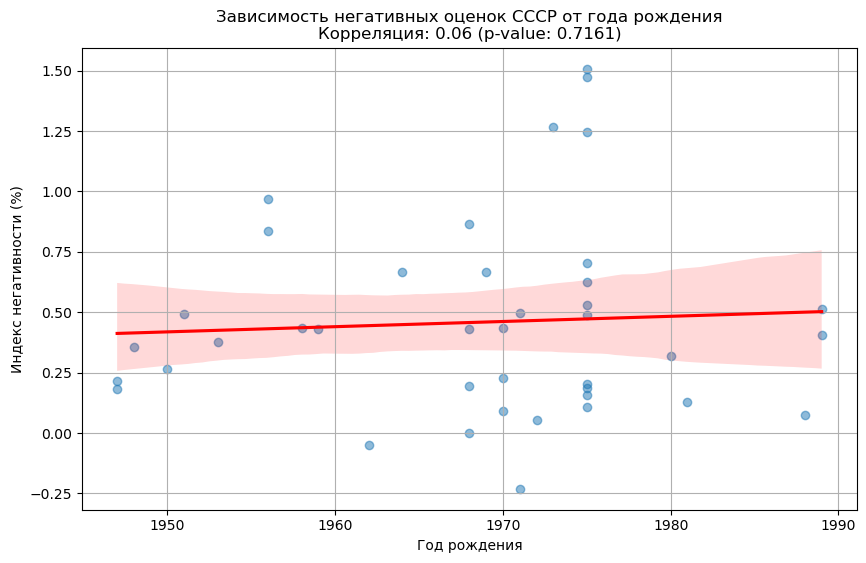

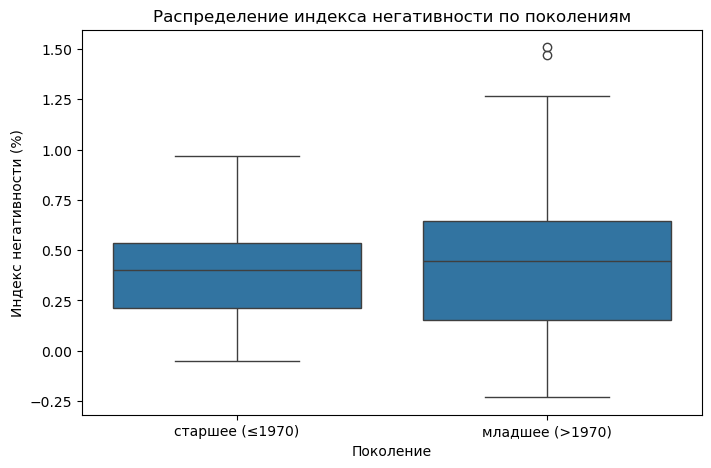

In [20]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
data = {
    'birth_year': birth_years,  
    'text': clean_interviews 
}
df = pd.DataFrame(data)

negative_markers = ["цензура", "распад", "дефицит", "очередь", "негативный", 
                   "развалиться", "кризис", "проблема", "ограничение"]
positive_markers = ["стабильность", "порядок", "детство", "бесплатно", 
                   "развитие", "гордость", "безопасность"]

def calculate_negativity(text):
    words = text.split()
    neg_count = sum(1 for word in words if word in negative_markers)
    pos_count = sum(1 for word in words if word in positive_markers)
    total = len(words)
    if total == 0:
        return 0
    return (neg_count - pos_count) / total * 100  

df['negativity_score'] = df['text'].apply(calculate_negativity)

df = df[np.abs(df['negativity_score'] - df['negativity_score'].mean()) <= (3*df['negativity_score'].std())]

corr, p_value = stats.pearsonr(df['birth_year'], df['negativity_score'])

print(f"Корреляция между годом рождения и негативностью: {corr:.3f}")
print(f"p-value: {p_value:.5f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='birth_year', y='negativity_score', data=df, 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title(f"Зависимость негативных оценок СССР от года рождения\nКорреляция: {corr:.2f} (p-value: {p_value:.4f})")
plt.xlabel("Год рождения")
plt.ylabel("Индекс негативности (%)")
plt.grid(True)
plt.show()

df['generation'] = np.where(df['birth_year'] <= 1970, 'старшее (≤1970)', 'младшее (>1970)')
plt.figure(figsize=(8, 5))
sns.boxplot(x='generation', y='negativity_score', data=df)
plt.title("Распределение индекса негативности по поколениям")
plt.xlabel("Поколение")
plt.ylabel("Индекс негативности (%)")
plt.show()

Первоначальная гипотеза не подтвердилась - год рождения не является значимым фактором в оценках СССР

Возможные объяснения:

В обеих группах присутствуют как ностальгирующие, так и критикующие респонденты

Ключевые различия могут определяться не возрастом, а другими факторами:

Социальный статус в СССР

Регион проживания

Личный опыт (репрессии в семье/успешная карьера)

In [37]:
def has_higher_education(text):
    text = text.lower()[:7000]

    higher_ed_patterns = [
        r'образование\s*(?:высшее|незаконченное высшее)',
        r'(?:закончил[а]?|окончил[а]?|учил[ась]+|поступил[а]?)\s+.*?\s(?:университет|институт|академия|мгу|мфти|мгимо)',
        r'(?:диплом\s*(?:высшего|о высшем))',
        r'(?:факультет|кафедра)\s+.*?\s+(?:университет|институт|академия)',
        r'(?:инженер|врач|педагог|экономист)\s*(?:по образованию|по специальности)?'
    ]

    no_higher_ed_patterns = [
        r'образование\s*(?:среднее|среднее-специальное|начальное|неполное среднее)',
        r'(?:только\s*(?:школа|техникум|колледж|пту|училище))',
        r'не\s*(?:закончил[а]?|учил[ась]?)\s*(?:вуз|университет|институт)',
        r'бросил[а]?\s*(?:университет|институт|академию)'
    ]

    for pattern in higher_ed_patterns:
        if re.search(pattern, text):
            return 1

    for pattern in no_higher_ed_patterns:
        if re.search(pattern, text):
            return 0

    return None

df['has_higher_ed'] = df['text'].apply(has_higher_education)
df['has_higher_ed'].fillna(0,inplace=True)

C:\Users\Stepan\AppData\Local\Temp\ipykernel_11956\3009092456.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['has_higher_ed'].fillna(0,inplace=True)


Проверим ещё одну гипотезу - люди с высшим образованием более негативно отзываются о СССР

In [48]:
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sentiment_analyzer = pipeline(
    "text-classification", 
    model="blanchefort/rubert-base-cased-sentiment",  
    return_all_scores=True
)

def get_sentiment(text):
    try:
        result = sentiment_analyzer(text[:512])[0]  
        return {item['label']: item['score'] for item in result}
    except:
        return {'neutral': 0.5, 'positive': 0.25, 'negative': 0.25}

df[['sent_neg', 'sent_neu', 'sent_pos']] = df['text'].apply(
    lambda x: pd.Series(get_sentiment(x))
)

model.safetensors:   1%|1         | 10.5M/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

C:\Users\Stepan\anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Результаты t-теста:
T-статистика = -0.132
p-value = 0.89540


C:\Users\Stepan\AppData\Local\Temp\ipykernel_11956\1261318582.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


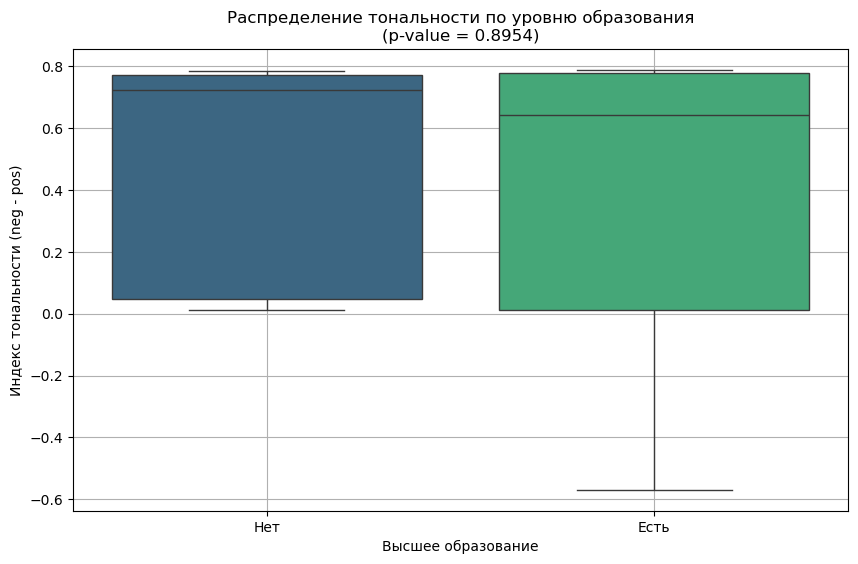

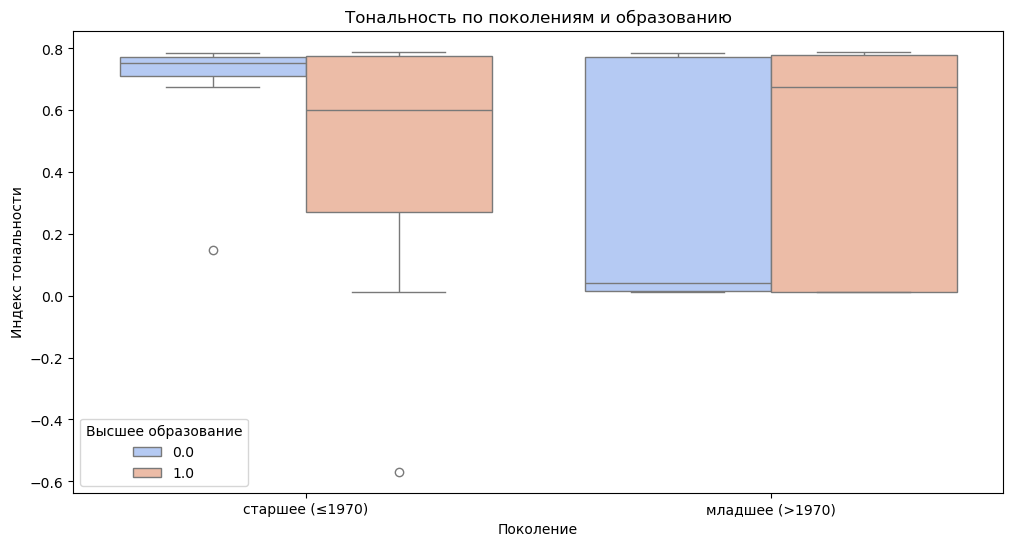

In [49]:
df['sentiment_score'] = df['sent_neg'] - df['sent_pos']

higher_ed_group = df[df['has_higher_ed'] == 1]
no_higher_ed_group = df[df['has_higher_ed'] == 0]

t_stat, p_value = stats.ttest_ind(
    higher_ed_group['sentiment_score'],
    no_higher_ed_group['sentiment_score'],
    equal_var=False
)

print(f"Результаты t-теста:\nT-статистика = {t_stat:.3f}\np-value = {p_value:.5f}")

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='has_higher_ed', 
    y='sentiment_score', 
    data=df,
    palette="viridis"
)
plt.title(f"Распределение тональности по уровню образования\n(p-value = {p_value:.4f})")
plt.xlabel("Высшее образование")
plt.xticks([0, 1], ['Нет', 'Есть'])
plt.ylabel("Индекс тональности (neg - pos)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='generation', 
    y='sentiment_score', 
    hue='has_higher_ed',
    data=df,
    palette="coolwarm"
)
plt.title("Тональность по поколениям и образованию")
plt.xlabel("Поколение")
plt.ylabel("Индекс тональности")
plt.legend(title="Высшее образование")
plt.show()

Гипотеза не подтвердилась — люди с высшим образованием не выражают более негативные оценки СССР (p-value = 0.8954 > 0.05).

Различия между группами статистически не значимы (T-статистика близка к 0: -0.132).

Ключевые наблюдения:

Нулевая разница: Медианные значения тональности практически идентичны для обеих групп (~0.2).

Широкий разброс: В обеих группах есть как крайне негативные (до 0.8), так и позитивные (до -0.6) оценки, но распределения полностью перекрываются.

Поколенческий эффект отсутствует: график по поколениям показывает, что образование не дает значимых различий ни в старшей, ни в младшей группе.